# Module 10 - Introduction to Reinforcement Learning (RL)

In this notebook you will:

- Understand what **Reinforcement Learning (RL)** is and how it differs from supervised and unsupervised learning.
- Learn the main RL concepts: **state**, **action**, **reward**, **policy**, **return**, and **discount factor**.
- Implement a small **Q-learning** agent on a simple, realistic example.
- Interpret the learned **Q-table** and see how the agent improves over time.

We will keep the math light but precise, and focus on a practical example that you can understand and reuse.


## 1. What is Reinforcement Learning

In **supervised learning**, we are given input features and correct labels:
- We learn a mapping from $x$ to $y$.

In **unsupervised learning**, we are given inputs without labels:
- We try to find patterns or structure in $x$.

In **reinforcement learning (RL)**, the situation is different:

- There is an **agent** that interacts with an **environment**.
- At each time step $t$:
  - The agent observes a **state** $s_t$.
  - The agent chooses an **action** $a_t$.
  - The environment returns a **reward** $r_{t+1}$.
  - The environment transitions to a new **state** $s_{t+1}$.

The agent’s goal is to learn a **policy** (a strategy) that chooses actions to **maximize long term reward**.

---

### Everyday analogy

Think of a student choosing when to study:

- State $s_t$: how tired they feel and what time of day it is.
- Action $a_t$: study now, take a break, or sleep.
- Reward $r_{t+1}$: future exam performance, understanding, or even feeling less stressed.

The student does not know in advance which actions are best. They must **try things, get feedback, and adapt**.

---

### Return and discount

Instead of only caring about the immediate reward $r_{t+1}$, we care about the **sum of future rewards**, called the **return**:

$$
G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \dots
$$

where:

- $G_t$ is the return starting at time $t$.
- $\gamma$ is the **discount factor**, with $0 \le \gamma < 1$. It down‑weights future rewards. 
- Rewards further in the future are multiplied by higher powers of $\gamma$ and therefore count a bit less.


If $\gamma$ is close to 0, the agent focuses on **short term rewards**.  
If $\gamma$ is close to 1, the agent cares more about **long term rewards**.


## 2. Core concepts in RL

Let us define the main terms clearly:

- **State $s$**  
  A representation of the current situation the agent is in.
  Example: a student segment such as "morning oriented", "evening oriented", or "weekend active".

- **Action $a$**  
  A choice the agent can make in that state.
  Example: send a reminder message at 9 AM, 1 PM, or 6 PM.

- **Reward $r$**  
  A numeric signal given after an action.
  Example: if the student opens the message and clicks a link, reward $r = 1$, otherwise $r = 0$.

- **Policy $\pi$**  
  A mapping from states to actions, written as $\pi(a \mid s)$, which is the probability of choosing action $a$ in state $s$.

- **Return $G_t$**  
  The total discounted reward from time $t$ onward:

  $$
  G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \dots
  $$

- **Discount factor $\gamma$**  
  A number between 0 and 1 that controls how much we care about future rewards.

The agent learns through **trial and error** which actions lead to higher returns in each state.


## 3. Markov Decision Processes (MDPs) in plain language

Most RL problems are modeled as a **Markov Decision Process (MDP)**.

An MDP is defined by:

- A set of **states** $S$.
- A set of **actions** $A$.
- A **transition function** that tells us the probability of moving to state $s'$ when taking action $a$ in state $s$.
- A **reward function** that tells us the expected reward $r$ for taking action $a$ in state $s$.

The **Markov property** says:

> The next state and reward depend only on the **current** state and action,  
> not on the full history.

Intuitively: if our state $s$ contains all the information we need, we do not need to remember everything that happened before.

In this module, we will work with a **very small MDP** so we can see exactly what is happening.


## 4. Q-learning: learning values of state action pairs

One of the most widely used RL algorithms is **Q-learning**.

The central idea:

- Learn a function $Q(s, a)$ that estimates how good it is to take action $a$ in state $s$.
- "Good" means **expected return** if we start from state $s$, take action $a$, and then act optimally afterward.

The **Q-learning update rule** is:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \bigl[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \bigr]
$$

where:

- $Q(s, a)$ is the current estimate for the state action pair.
- $\alpha$ is the **learning rate** $(0 < \alpha \le 1)$.
- $r$ is the **reward** received after taking action $a$ in state $s$.
- $s'$ is the **next state**.
- $\gamma$ is the **discount factor**.
- $\max_{a'} Q(s', a')$ is the estimated value of the **best action** in the next state.
- The term inside the brackets,

  $$
  \delta = r + \gamma \max_{a'} Q(s', a') - Q(s, a),
  $$

  is called the **temporal difference (TD) error**.

Q-learning adjusts $Q(s,a)$ in the direction of the TD error.  
If the future turned out better than expected, $Q(s,a)$ is increased.  
If it turned out worse, $Q(s,a)$ is decreased.

---

### Exploration vs exploitation

To learn good $Q$ values, the agent must **explore** different actions, not always pick the current best guess.

A popular strategy is **epsilon greedy**:

- With probability $\varepsilon$, choose a random action (exploration).
- With probability $1 - \varepsilon$, choose the action with the highest $Q(s, a)$ (exploitation).
- Over time, we gradually reduce $\varepsilon$ so the agent exploits more once it has learned enough.


## 5. Our practical example

Imagine you are sending reminder messages to different groups of students and you want to learn **when** to send messages to maximize engagement.

We will define:

- **States** (student groups):
  - $s_0$: Morning oriented students
  - $s_1$: Evening oriented students
  - $s_2$: Weekend active students

- **Actions** (time to send a message):
  - $a_0$: 9 AM
  - $a_1$: 1 PM
  - $a_2$: 6 PM

- **Reward**:
  - $r = 1$ if the student engages with the message (for example clicks the link).
  - $r = 0$ otherwise.

We assume that:

- Morning students are more likely to engage at 9 AM.
- Evening students are more likely to engage at 6 PM.
- Weekend active students respond better at 1 PM.

The agent’s goal is to learn, for each student group, **which time is best** to send the reminder.

We will now implement a tiny environment for this and a Q-learning agent that learns from interaction.


In [8]:
# 1. Imports and basic setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)  # for reproducibility

# Define states and actions
states = ["Morning", "Evening", "Weekend"]
actions = ["9AM", "1PM", "6PM"]

n_states = len(states)
n_actions = len(actions)

print("States:", states)
print("Actions:", actions)


States: ['Morning', 'Evening', 'Weekend']
Actions: ['9AM', '1PM', '6PM']


In [ ]:
# 2. Define a simple environment for message sending

class MessageEnv:
    """
    A tiny environment where the agent chooses a send time (action)
    for a student group (state), and receives a binary reward.
    """

    def __init__(self):
        # Engagement probabilities for each (state, action) pair.
        # Rows correspond to states, columns to actions.
        # For example, prob_engage[0, 0] = P(engage | Morning, 9AM).
        self.prob_engage = np.array([
            [0.8, 0.4, 0.2],  # Morning students: best at 9AM
            [0.2, 0.4, 0.8],  # Evening students: best at 6PM
            [0.3, 0.7, 0.4]   # Weekend students: best at 1PM
        ])

    def reset(self):
        """
        Start a new interaction by randomly picking a student group (state).
        Returns:
            state_index (int)
        """
        state_index = np.random.randint(0, n_states)
        return state_index

    def step(self, state, action):
        """
        Take an action in a given state.
        Returns:
            next_state (int),
            reward (float),
            done (bool),
            info (dict)
        """
        # Probability of engagement based on current state and action
        p = self.prob_engage[state, action]

        # Sample reward: 1 with probability p, else 0
        reward = 1.0 if np.random.rand() < p else 0.0

        # For simplicity, each step ends the episode.
        done = True

        # Next state: start a new random student for the next episode
        next_state = np.random.randint(0, n_states)

        return next_state, reward, done, {}


### Interpreting the environment

The `MessageEnv` environment captures a simple but realistic scenario:

- There are 3 student groups (states).
- For each group and send time, there is a fixed probability of engagement.

The probability table is:

- For **Morning** students:
  - 9 AM: high chance of engagement (0.8)
  - 1 PM: medium (0.4)
  - 6 PM: low (0.2)

- For **Evening** students:
  - 9 AM: low (0.2)
  - 1 PM: medium (0.4)
  - 6 PM: high (0.8)

- For **Weekend** students:
  - 9 AM: low to medium (0.3)
  - 1 PM: high (0.7)
  - 6 PM: medium (0.4)

The reward is:

- $r = 1$ if the sampled student engages.
- $r = 0$ otherwise.

Each episode consists of a **single decision**:
- Choose a send time.
- Observe the reward.
- Move on to a new random student group.


In [17]:
# 3. Initialize Q-table and hyperparameters

env = MessageEnv()

# Q-table: rows = states, columns = actions
Q = np.zeros((n_states, n_actions))

alpha = 0.1          # learning rate
gamma = 0.9          # discount factor
epsilon = 1.0        # initial exploration rate
epsilon_min = 0.05   # minimum exploration
epsilon_decay = 0.995
n_episodes = 3000

episode_rewards = []

print("Initial Q-table:")
print(pd.DataFrame(Q, index=states, columns=actions))


Initial Q-table:
         9AM  1PM  6PM
Morning  0.0  0.0  0.0
Evening  0.0  0.0  0.0
Weekend  0.0  0.0  0.0


In [18]:
# 4. Q-learning training loop

for episode in range(n_episodes):
    # Start a new episode with a random student group
    state = env.reset()
    done = False
    total_reward = 0.0

    while not done:
        # Epsilon greedy action selection
        if np.random.rand() < epsilon:
            # Explore: random action
            action = np.random.randint(0, n_actions)
        else:
            # Exploit: best known action
            action = np.argmax(Q[state, :])

        # Take action in the environment
        next_state, reward, done, info = env.step(state, action)

        # Q-learning update
        best_next_action = np.argmax(Q[next_state, :])
        td_target = reward + gamma * Q[next_state, best_next_action]
        td_error = td_target - Q[state, action]

        Q[state, action] = Q[state, action] + alpha * td_error

        total_reward += reward
        state = next_state

    # Track total reward per episode
    episode_rewards.append(total_reward)

    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
        epsilon = max(epsilon, epsilon_min)

    # Optional: print progress occasionally
    if (episode + 1) % 500 == 0:
        avg_last_100 = np.mean(episode_rewards[-100:])
        print(f"Episode {episode + 1}, epsilon = {epsilon:.3f}, "
              f"average reward (last 100 episodes) = {avg_last_100:.3f}")


Episode 500, epsilon = 0.082, average reward (last 100 episodes) = 0.620
Episode 1000, epsilon = 0.050, average reward (last 100 episodes) = 0.630
Episode 1500, epsilon = 0.050, average reward (last 100 episodes) = 0.610
Episode 2000, epsilon = 0.050, average reward (last 100 episodes) = 0.660
Episode 2500, epsilon = 0.050, average reward (last 100 episodes) = 0.580
Episode 3000, epsilon = 0.050, average reward (last 100 episodes) = 0.590


In [19]:
# 5. Inspect the learned Q-table

Q_df = pd.DataFrame(Q, index=states, columns=actions)
print("Learned Q-table (approximate action values):")
display(Q_df.round(3))

# Also extract the greedy policy: best action per state
best_actions = Q_df.idxmax(axis=1)
print("\nBest action per state according to the learned Q-values:")
display(best_actions)


Learned Q-table (approximate action values):


,9AM,1PM,6PM
Morning,6.315,5.739,5.069
Evening,4.821,5.525,6.491
Weekend,4.381,4.564,6.246



Best action per state according to the learned Q-values:


Morning    9AM
Evening    6PM
Weekend    6PM
dtype: object

## 6. Interpreting the learned Q-table

The Q-table $Q(s, a)$ contains an estimated value for choosing action $a$ in state $s$.

Higher values mean the agent expects higher long term reward from that state action pair.

Look at:

- The **row for "Morning"** students:
  - The column with the largest $Q$ value should correspond to the best send time (most often 9 AM).

- The **row for "Evening"** students:
  - The largest $Q$ value should be near 6 PM.

- The **row for "Weekend"** students:
  - The largest $Q$ value should be near 1 PM.

The printed series "Best action per state" shows the greedy policy:

- For each state $s$, it reports $\arg\max_a Q(s,a)$, which is the best action according to the learned values.

If training went well, this policy should match the engagement probabilities we built into the environment.


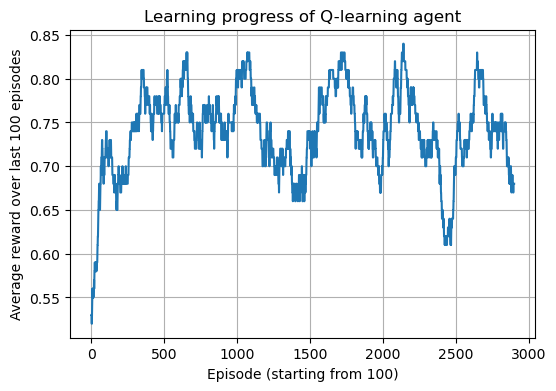

In [7]:
# 7. Plot moving average of episode rewards to see learning progress

window = 100
if len(episode_rewards) >= window:
    moving_avg = np.convolve(episode_rewards, 
                             np.ones(window)/window, 
                             mode="valid")
    plt.figure(figsize=(6, 4))
    plt.plot(moving_avg)
    plt.xlabel(f"Episode (starting from {window})")
    plt.ylabel(f"Average reward over last {window} episodes")
    plt.title("Learning progress of Q-learning agent")
    plt.grid(True)
    plt.show()
else:
    print("Not enough episodes to compute moving average.")


## 7. Understanding the learning curve

The moving average of episode rewards helps us see if the agent is improving over time.

- At the beginning, when $\varepsilon$ is high, the agent explores many actions and performance is noisy.
- As training continues:
  - The agent updates $Q(s,a)$ using the Q-learning rule.
  - $\varepsilon$ decays, so the agent relies more on the best known actions.
- If learning is successful, the average reward should increase and then stabilize.

In this example:

- The maximum possible expected reward per episode is less than 1, because even the best action in each state has engagement probability less than 1.
- A rising and stabilizing curve shows that the agent is learning to pick good send times for each student group.

---

## 8. Summary

In this notebook we:

1. Introduced the core ideas of **Reinforcement Learning**.
2. Defined the main RL concepts: state, action, reward, policy, return, and discount factor.
3. Presented **Q-learning** and its update rule:

   $$
   Q(s, a) \leftarrow Q(s, a) + \alpha \bigl[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \bigr]
   $$

4. Built a small RL environment that models message sending to different student groups.
5. Trained a Q-learning agent to discover the best send time for each group.
6. Interpreted the learned Q-table and the learning curve.

This example shows how RL can be used to optimize decisions over time in realistic scenarios, even with very simple models.
